# Decision Tree

In [5]:
import numpy as np

from sklearn.metrics import accuracy_score

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## 1. Построение критерия и вычисление предиката

In [6]:
class Criterion:
    def get_best_split(self, feature, target):
        """
        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """

        indices = feature.argsort()
        target_srt = target[indices]
        N = len(target)

        q_best = -np.inf
        i_best = None

        h_0 = self.score(target)

        for i in range(1, N):
            h_l = self.score(target_srt[:i])
            h_r = self.score(target_srt[i:])

            q = h_0 - i / N * h_l - (N - i) / N * h_r
            if q > q_best:
                q_best = q
                i_best = i

        threshold = (feature[indices[i_best]] + feature[indices[i_best - 1]]) / 2
        return threshold, q_best

    def score(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """

    def get_predict_val(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: probability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength=self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - (pred**2).sum()


class EntropyCriterion(Criterion):
    EPS = 1e-6

    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength=self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return -(pred * np.log(pred + self.EPS)).sum()


class MSECriterion(Criterion):
    def get_predict_val(self, target):
        return np.mean(target)

    def score(self, target):
        N = len(target)
        pred = self.get_predict_val(target)
        return (np.sum((target - pred) ** 2)) / N

## 2. Вычисление параметров предиката и разбиение вершины дерева

In [11]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity  # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth  # current node depth

        self.feature = None  # feature to split
        self.threshold = None  # threshold to split
        self.improvement = -np.inf  # node impurity improvement after split

        self.child_left = None
        self.child_right = None

    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None

    @classmethod
    def get_best_split(cls, X, y, criterion):
        """
        Finds best split for current node

        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )

        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        """

        q_best = -np.inf
        t_best = None
        f_best = None

        for fi in range(X.shape[1]):
            thr, q = criterion.get_best_split(X[:, fi], y)
            if q > q_best:
                q_best = q
                t_best = thr
                f_best = fi

        return f_best, t_best, q_best

    def get_best_split_mask(self, X):
        """
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)

        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        """

        return X[:, self.feature] >= self.threshold

    def split(self, X, y, criterion, **split_params):
        """
        Split current node

        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method

        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool

        child_left  : TreeNode
        child_right : TreeNode
        """

        self.feature = split_params["feature"]
        self.threshold = split_params["threshold"]
        self.improvement = split_params["improvement"]

        mask_right_child = self.get_best_split_mask(X)
        self.child_left = self.from_criterion(
            y[~mask_right_child], criterion, self.depth + 1
        )
        self.child_right = self.from_criterion(
            y[mask_right_child], criterion, self.depth + 1
        )

        return mask_right_child, self.child_left, self.child_right

    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )

## 3. Реализация дерева.

В классе `DecisionTree` вам необходимо реализованы следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [16]:
from collections import deque


class DecisionTree:
    def __init__(self, max_depth=None, min_leaf_size=None, min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement
        self.n_features = None

    def _build_nodes(self, X, y, criterion, indices, node):
        """
        Builds tree recursively

        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        """
        self.n_features = X.shape[1]

        if self.max_depth is not None and node.depth >= self.max_depth:
            return

        if self.min_leaf_size is not None and self.min_leaf_size > len(indices):
            return

        if np.unique(y[indices]).shape[0] <= 1:
            return

        X_node, y_node = X[indices], y[indices]
        feature, thr, impr = node.get_best_split(X_node, y_node, criterion)

        if self.min_improvement is not None and self.min_improvement > improvement:
            return

        mask_right, child_left, child_right = node.split(
            X_node, y_node, criterion, feature=feature, threshold=thr, improvement=impr
        )

        self._build_nodes(X, y, criterion, indices[~mask_right], child_left)
        self._build_nodes(X, y, criterion, indices[mask_right], child_right)

    def _get_nodes_predictions(self, X, predictions, indices, node):
        """
        Builds tree recursively

        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        """
        for k, obj in enumerate(X):
            curr_node = node
            while not curr_node.is_terminal:
                curr_feature = curr_node.feature
                curr_threshold = curr_node.threshold
                if obj[curr_feature] < curr_threshold:
                    curr_node = curr_node.child_left
                else:
                    curr_node = curr_node.child_right

            y_pred = curr_node.predict_val
            # print(y_pred)
            predictions[k] = y_pred

        return self

    @property
    def feature_importances_(self):
        """
        Returns
        -------
        importance : cummulative improvement per feature, np.ndarray.shape = (n_features, )
        """
        importance = np.zeros(self.n_features)

        queue = deque()
        queue.append(self.root_)

        while len(queue):
            node = queue.popleft()
            if node.is_terminal:
                continue

            importance[node.feature] += node.improvement
            queue.append(node.child_left)
            queue.append(node.child_right)

        return importance

In [17]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion="gini", **kwargs):
        super().__init__(**kwargs)

        if criterion not in (
            "gini",
            "entropy",
        ):
            raise ValueError("Unsupported criterion", criterion)
        self.criterion = criterion

    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]

        if self.criterion == "gini":
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == "entropy":
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError("Unsupported criterion", criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

In [18]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack(
    (
        np.random.normal(loc=(-5, -5), size=(100, 2)),
        np.random.normal(loc=(-5, 5), size=(100, 2)),
        np.random.normal(loc=(5, -5), size=(100, 2)),
        np.random.normal(loc=(5, 5), size=(100, 2)),
    )
)

some_y = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [20]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [21]:
assert (some_tree.feature_importances_ == [0.25, 1.0]).all()

In [22]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack(
    (
        np.random.normal(loc=(-5, -5), size=(100, 2)),
        np.random.normal(loc=(-5, 5), size=(100, 2)),
        np.random.normal(loc=(5, -5), size=(100, 2)),
        np.random.normal(loc=(5, 5), size=(100, 2)),
    )
)

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [23]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

## 4. Визуализация результатов



In [24]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt

%matplotlib inline

Функция для визуализации двумерной выборки:

In [25]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)

    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], "o")

Функция для визуализации работы дерева на двумерной выборке:

In [26]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap="Spectral", figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)

    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(
        *X[y_pred == y].T,
        marker=".",
        s=70,
        c=y[y_pred == y],
        cmap=cmap,
        alpha=0.9,
        label="correct"
    )
    plt.scatter(
        *X[y_pred != y].T, marker="x", s=50, c=y[y_pred != y], cmap=cmap, label="errors"
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("tight")
    plt.legend(loc="best")
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

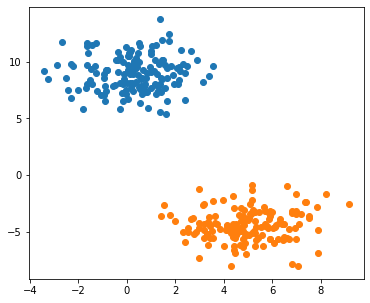

In [27]:
X, y = make_blobs(
    n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23
)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [28]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

Accuracy = 1.0


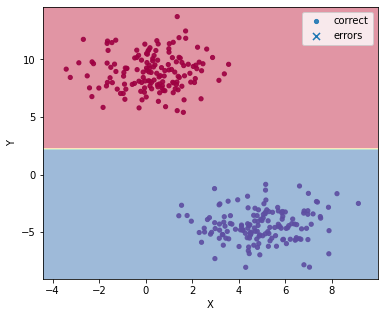

In [29]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [30]:
X, y = make_blobs(
    n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23
)

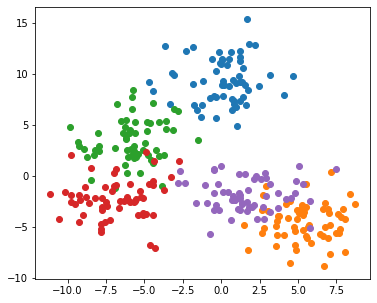

In [31]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.4


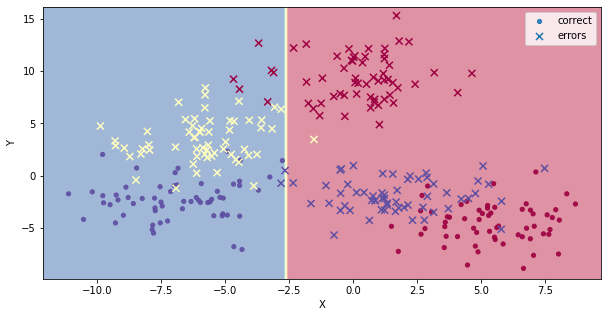

In [32]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7466666666666667


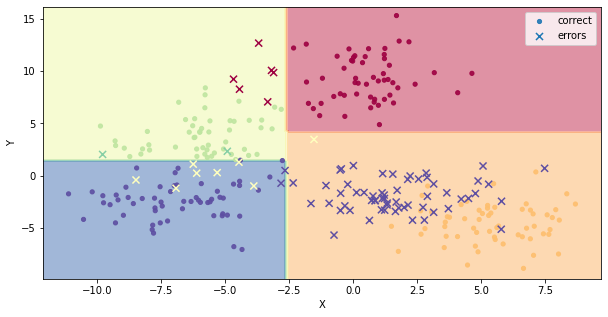

In [33]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.89


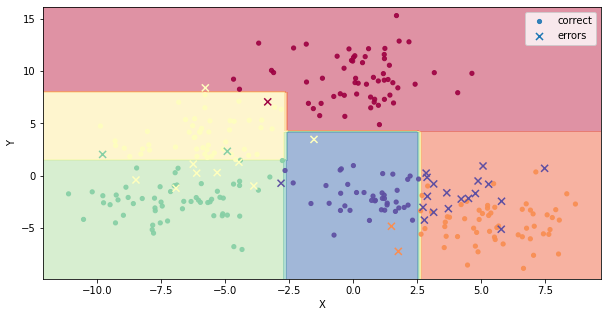

In [34]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.94


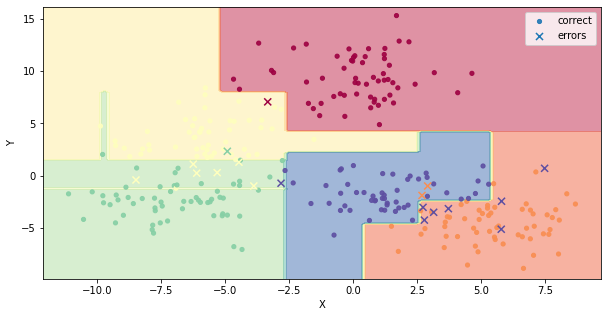

In [35]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


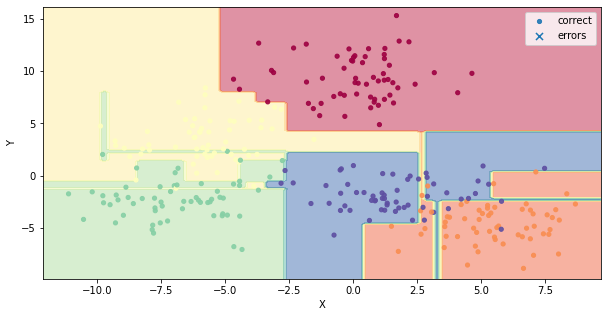

In [36]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

Accuracy = 0.95


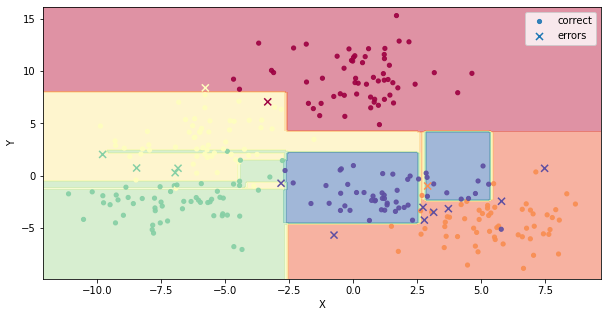

In [37]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


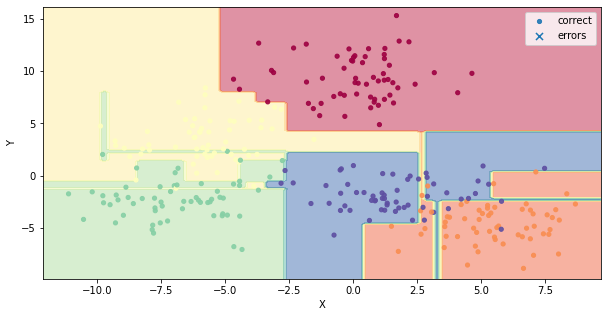

In [38]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

# Regression Tree

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.datasets import fetch_california_housing
from itertools import product
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

In [40]:
class RegressionDecisionTree(DecisionTree):
    def __init__(self, criterion="mse", **kwargs):
        super().__init__(**kwargs)

        if criterion not in ("mse",):
            raise ValueError("Unsupported criterion", criterion)
        self.criterion = criterion

    def fit(self, X, y):
        # self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]

        if self.criterion == "mse":
            criterion = MSECriterion()
        else:
            raise ValueError("Unsupported criterion", criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self

    def predict(self, X):
        probas = np.zeros(shape=(X.shape[0]))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

In [41]:
some_tree = RegressionDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack(
    (
        np.random.normal(loc=(-10), size=(100, 1)),
        np.random.normal(loc=(10), size=(100, 1)),
        np.random.normal(loc=(50), size=(100, 1)),
        np.random.normal(loc=(100), size=(100, 1)),
    )
)

some_y = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [42]:
assert np.isclose(predictions, some_y).all()

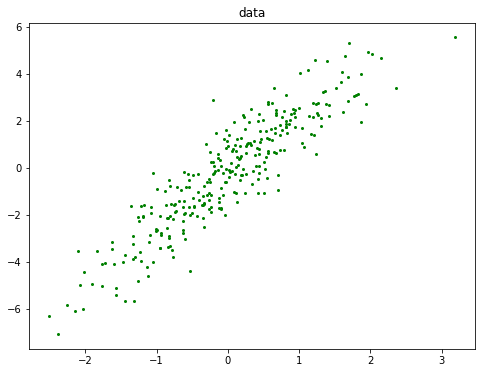

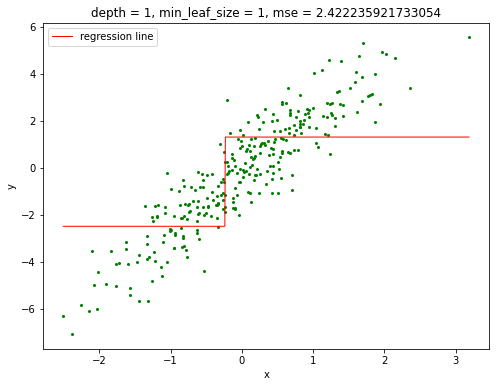

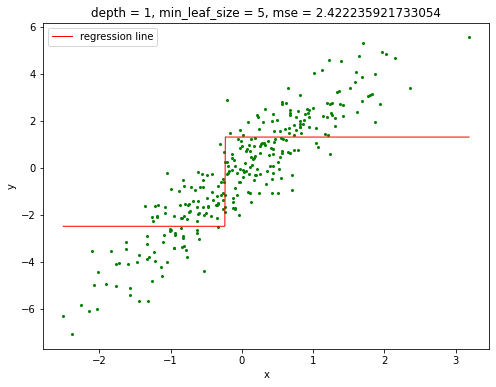

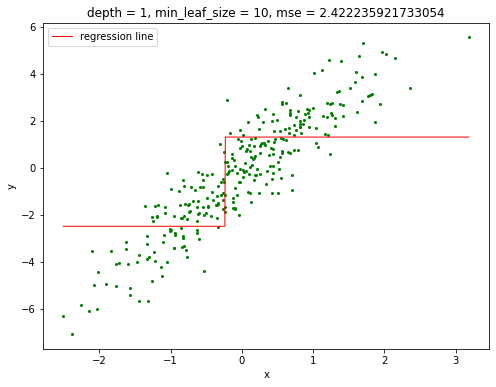

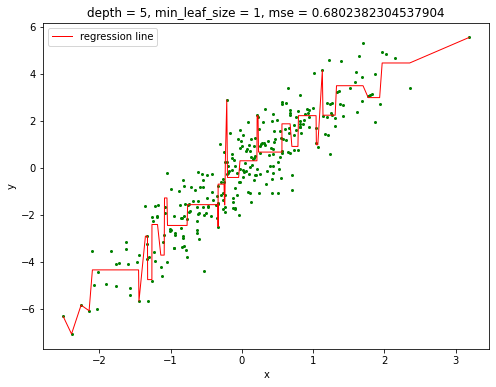

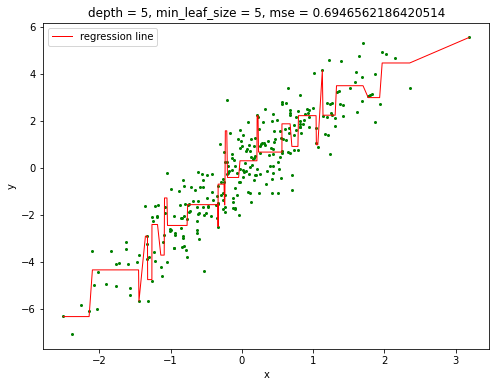

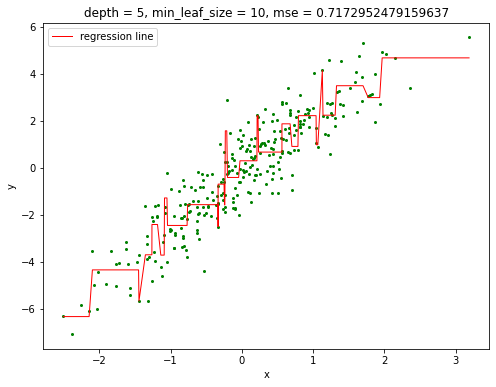

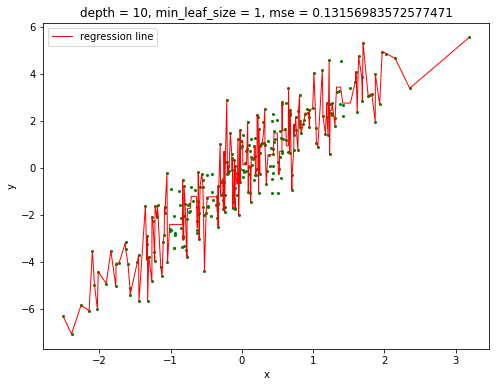

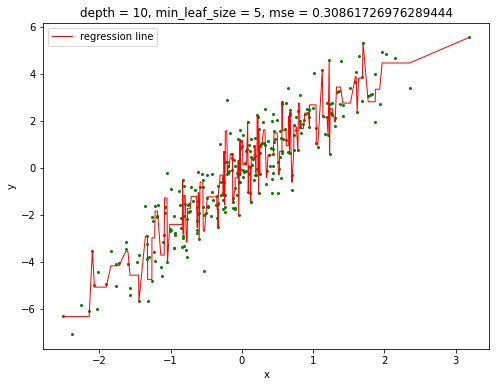

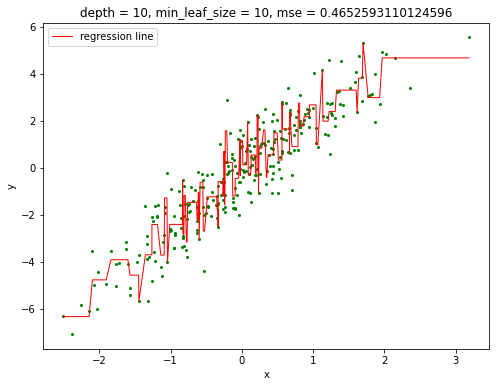

In [43]:
depth = [1, 5, 10]
leaf_size = [1, 5, 10]
combination = list(product(depth, leaf_size))
X, y = make_regression(
    n_samples=300, n_features=1, n_informative=1, random_state=23, noise=1
)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, color="green", zorder=1, s=4)
plt.title("data")
plt.show()

for d, ls in combination:
    some_tree = RegressionDecisionTree(max_depth=d, min_leaf_size=ls)
    some_tree.fit(X, y)
    y_pred = some_tree.predict(X)

    mse = mean_squared_error(y_pred, y)

    # sorting
    # https://stackoverflow.com/questions/53895723/sorted-data-not-plotted-in-correct-datapoints
    argsort_X_test = np.argsort((X[:, 0].ravel()))
    X_test_sort = X[argsort_X_test, 0]
    y_pred_test_sine_sort = y_pred[argsort_X_test]

    # plotting
    plt.figure(figsize=(8, 6))
    plt.plot(
        X_test_sort,
        y_pred_test_sine_sort,
        zorder=2,
        linewidth=1.0,
        color="red",
        label="regression line",
    )
    plt.scatter(X, y, color="green", zorder=1, s=4)
    plt.title("depth = {}, min_leaf_size = {}, mse = {}".format(d, ls, mse))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# California housing

In [201]:
X = fetch_california_housing()["data"]
y = fetch_california_housing()["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [213]:
depth = [1, 3, 5, 7, 10, 15, 20]
leaf_size = [1, 3, 5, 7, 10, 15, 20]
combination = list(product(depth, leaf_size))
result = defaultdict()

In [244]:
for d, ls in tqdm(combination):
    try:
        some_tree = RegressionDecisionTree(max_depth=d, min_leaf_size=ls)
        some_tree.fit(X_train, y_train)
        y_pred = some_tree.predict(X_val)

        mse = mean_squared_error(y_pred, y_val)
        result[d, ls] = mse
    except ValueError:
        continue

100%|██████████| 49/49 [16:13<00:00, 19.87s/it]


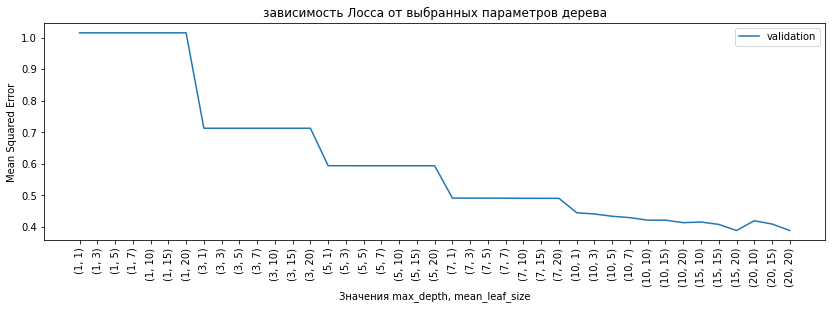

In [245]:
keys = list(result.keys())
res_val = list(result.values())

plt.figure(figsize=(14, 4))
plt.plot(np.arange(len(keys)), res_val, label="validation")
plt.xticks(np.arange(len(keys)), keys, rotation="vertical")
plt.xlabel("Значения max_depth, mean_leaf_size")
plt.ylabel("Mean Squared Error")
plt.title("зависимость Лосса от выбранных параметров дерева")
plt.legend()
plt.show()

print()

In [246]:
opt_d, opt_ls = min(result, key=result.get)

In [247]:
opt_tree = RegressionDecisionTree(max_depth=opt_d, min_leaf_size=opt_ls)
opt_tree.fit(X_train, y_train)
y_pred = some_tree.predict(X_test)

mse = mean_squared_error(y_pred, y_test)

In [249]:
mse

0.3859286273464832